In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from tqdm import tqdm

POSTGRES_ADDRESS = 'db.panoply.io' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5439'
POSTGRES_USERNAME = 'vin.tang@gmail.com' ## CHANGE THIS TO YOURPANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'Cobalt27!' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'playerslounge_prod' ## CHANGE THIS TO YOUR DATABASE NAME

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

In [2]:
query = """
select contests.id, contests.__updatetime, contests.type, contests_plrsbefore.plr, contests.winner, contests.loser, contests_plrsbefore.userid, contests.status
from contests 
inner join contests_plrsbefore 
on contests.id = contests_plrsbefore.contests_id
where contests.console_game = 'ps4-nba21'
"""

In [3]:
df = pd.read_sql_query(query, cnx)
df.shape

(69444, 8)

In [4]:
df.head()

,id,__updatetime,type,plr,winner,loser,userid,status
0,2243988808407448,2020-09-04 05:12:16.797,H,50,6.210912e+14,3.559349e+15,621091246611789,completed
1,2156599449300926,2020-09-04 05:12:16.797,H,55,NaN,NaN,4208838072140441,cancelled
2,3327488311065932,2020-09-04 05:12:16.797,H,49,NaN,NaN,8023059477777343,cancelled
3,4140778429694488,2020-09-04 05:12:16.797,H,71,6.573307e+15,7.090778e+15,7090777804695185,completed
4,4496887499213898,2020-09-04 05:12:16.797,H,69,NaN,NaN,1041621141461443,cancelled


In [5]:
lookup = {}

for _, row in tqdm(df.iterrows()):
    if row['status'] != "completed" or row['type'] != 'H':
        pass
    else:
        if row['id'] not in lookup.keys():
            if row['userid'] == row['winner']:
                lookup[row['id']] = {"winner": row['plr']}
            else:
                lookup[row['id']] = {"loser": row['plr']}
        else:
            if row['userid'] == row['winner']:
                lookup[row['id']]['winner'] = row['plr']
            else:
                lookup[row['id']]['loser'] = row['plr']
        lookup[row['id']]['time'] = row['__updatetime']

69444it [00:09, 7071.00it/s]


In [6]:
contest = []
winner = []
loser = []
time = []

for k, v in lookup.items():
    contest.append(k)
    winner.append(v['winner'])
    loser.append(v['loser'])
    time.append(v['time'])

In [7]:
outcomes = {'contest':contest, 'winner':winner, 'loser':loser, 'time':time}
data = pd.DataFrame.from_dict(outcomes)
data.head()

,contest,winner,loser,time
0,2243988808407448,50,44,2020-09-04 05:12:16.797
1,4140778429694488,84,71,2020-09-04 05:12:16.797
2,7793463253342686,97,79,2020-09-04 05:12:16.797
3,4648818299169703,79,97,2020-09-04 07:13:22.282
4,6051838258797933,95,86,2020-09-04 07:13:22.282


In [15]:
correct = 0
count = 0

for k, v in lookup.items():
    if len(v.keys()) == 3:
        count += 1
        if v['winner'] >= v['loser']:
            correct += 1

In [16]:
correct/ count

0.6237570322393141

In [17]:
lookup['5148940047099294']

{'loser': 44, 'time': Timestamp('2020-08-21 19:15:34.342000'), 'winner': 74}

# plot 2: winning percentage versus games played

In [35]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [36]:
df.head()

,id,__updatetime,type,plr,winner,loser,userid,status
0,2243988808407448,2020-09-04 05:12:16.797,H,44,6.210912e+14,3.559349e+15,3559348654747294,completed
1,437079378148688,2020-09-04 05:12:16.797,H,49,NaN,NaN,8023059477777343,cancelled
2,5866612100466631,2020-09-04 05:12:16.797,H,49,NaN,NaN,8023059477777343,cancelled
3,6326982571124685,2020-09-04 05:12:16.797,H,68,NaN,NaN,4971679466233292,cancelled
4,7963991115850207,2020-09-04 05:12:16.797,H,74,7.277532e+15,3.239407e+15,3239407316472950,completed


In [37]:
lookup = {}

for _, row in tqdm(df.iterrows()):
    if row['status'] != "completed" or row['type'] != 'H':
        pass
    else:
        if row['userid'] not in lookup.keys():
            if row['userid'] == row['winner']:
                lookup[row['userid']] = [1]
            else:
                lookup[row['userid']] = [0]
        else:
            if row['userid'] == row['winner']:
                lookup[row['userid']].append(1)
            else:
                lookup[row['userid']].append(0)

69056it [00:08, 7684.30it/s]


In [38]:
winning_percentage = []
games_played = []

for v in lookup.values():
    winning_percentage.append(np.mean(v))
    games_played.append(len(v))

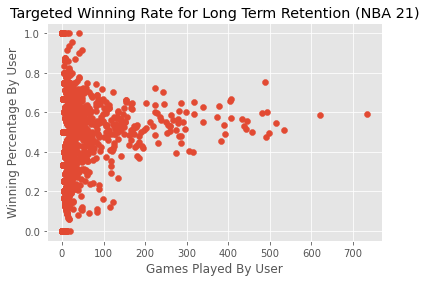

In [40]:
plt.title('Targeted Winning Rate for Long Term Retention (NBA 21)')
plt.ylabel('Winning Percentage By User')
plt.xlabel('Games Played By User')
plt.scatter(games_played, winning_percentage)

# chart 3 common paths

In [42]:
df['__updatetime'][1]

Timestamp('2020-09-04 05:12:16.797000')

In [43]:
df['__updatetime'][100]

Timestamp('2020-09-05 05:04:08.325000')

In [45]:
df['__updatetime'][1] > df['__updatetime'][100]

False

In [46]:
df.head()

,id,__updatetime,type,plr,winner,loser,userid,status
0,2243988808407448,2020-09-04 05:12:16.797,H,44,6.210912e+14,3.559349e+15,3559348654747294,completed
1,437079378148688,2020-09-04 05:12:16.797,H,49,NaN,NaN,8023059477777343,cancelled
2,5866612100466631,2020-09-04 05:12:16.797,H,49,NaN,NaN,8023059477777343,cancelled
3,6326982571124685,2020-09-04 05:12:16.797,H,68,NaN,NaN,4971679466233292,cancelled
4,7963991115850207,2020-09-04 05:12:16.797,H,74,7.277532e+15,3.239407e+15,3239407316472950,completed


In [47]:
lookup = {}

for _, row in tqdm(df.iterrows()):
    if row['status'] != "completed" or row['type'] != 'H':
        pass
    else:
        if row['userid'] not in lookup.keys():
            if row['userid'] == row['winner']:
                lookup[row['userid']] = [(row['__updatetime'], 1)]
            else:
                lookup[row['userid']] = [(row['__updatetime'], 0)]
        else:
            if row['userid'] == row['winner']:
                lookup[row['userid']].append((row['__updatetime'], 1))
            else:
                lookup[row['userid']].append((row['__updatetime'], 0))

69056it [00:09, 7194.71it/s]


In [51]:
# sort games
for k, v in lookup.items():
    lookup[k] = sorted(v, key=lambda x: x[0])

In [55]:
# remove timespace
for k, v in lookup.items():
    lookup[k] = list(map(lambda x: x[1], v))

In [57]:
# insert end 
for k, v in lookup.items():
    lookup[k].append("*")
lookup

{3559348654747294: [0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  